In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

REPO_ROOT = Path.cwd().parents[0]
PROCESSED = REPO_ROOT/"data/processed"
# load training splits ONLY
customers_train = pd.read_csv(PROCESSED/"customers_train.csv")
txns_train = pd.read_csv(PROCESSED/"transactions_train.csv")

print("customers_train:", customers_train.shape)
print("txns_train:", txns_train.shape)

customers_train.head()


customers_train: (700, 18)
txns_train: (43004, 31)


,birth_date,city,country,customer_id,customer_type,employee_count,established_date,gender,income,industry,industry_code,marital_status,occupation_code,occupation_title,onboard_date,province,sales,label
0,1972-12-07,other,CA,SYNID0108676505,individual,NaN,NaN,MALE,123875.0,Unknown,Unknown,Married,SELF_EMPLOYED,Unknown,2001-03-17,Unknown,NaN,0.0
1,1964-02-20,other,CA,SYNID0104294551,individual,NaN,NaN,FEMALE,NaN,Unknown,Unknown,Single,RETIRED,Unknown,2010-06-12,Unknown,NaN,0.0
2,1986-04-08,MONTREAL,CA,SYNID0108958094,individual,NaN,NaN,MALE,NaN,Unknown,Unknown,Unknown,OTHER,Unknown,2016-03-25,QC,NaN,0.0
3,1999-04-08,KINGSTON,CA,SYNID0102414463,individual,NaN,NaN,FEMALE,NaN,Unknown,Unknown,Single,SELF_EMPLOYED,Unknown,2021-08-17,ON,NaN,0.0
4,1935-05-02,BRAMPTON,CA,SYNID0100000485,individual,NaN,NaN,FEMALE,19998.0,Unknown,Unknown,Widowed,RETIRED,Unknown,1997-07-12,ON,NaN,0.0


In [4]:
tx = txns_train.copy()

tx["amount_cad"] = pd.to_numeric(tx["amount_cad"], errors="coerce")
tx["cash_indicator"] = tx["cash_indicator"].fillna(0).astype(int)

tx["is_debit"] = tx["debit_credit"].astype(str).str.upper().eq("D")
tx["is_credit"] = tx["debit_credit"].astype(str).str.upper().eq("C")

tx["transaction_datetime"] = pd.to_datetime(tx["transaction_datetime"], errors="coerce")

tx.head()


,transaction_id,customer_id,amount_cad,debit_credit,transaction_datetime,cash_indicator,country_x,province_x,city_x,channel,...,income,industry,industry_code,marital_status,occupation_code,occupation_title,onboard_date,province_y,sales,label
0,ABM2411011564159,SYNID0106538257,1040.0,D,2024-11-01 02:46:45,1,CA,ON,MISSISSAUGA,abm,...,47378.0,Unknown,Unknown,Single,RETIRED,Unknown,2001-10-01,AB,NaN,0.0
1,ABM2411013653731,SYNID0104011970,110.0,D,2024-11-01 07:24:56,1,CA,NL,other,abm,...,138602.0,Unknown,Unknown,Married,10010,Financial managers,NaN,AB,NaN,0.0
2,ABM2411019946491,SYNID0109183244,100.0,D,2024-11-01 08:28:52,1,Unknown,Unknown,other,abm,...,105612.0,Unknown,Unknown,Married,21222,Information systems specialists,1999-07-09,AB,NaN,0.0
3,ABM2411012512881,SYNID0108646125,100.0,D,2024-11-01 11:11:05,1,CA,NL,other,abm,...,78155.0,Unknown,Unknown,Married,20012,Computer and information systems managers,1997-11-21,AB,NaN,0.0
4,ABM2411019428340,SYNID0104697222,60.0,C,2024-11-01 11:27:05,0,CA,ON,LONDON,abm,...,39456.0,Unknown,Unknown,Married,SELF_EMPLOYED,Unknown,1997-10-26,Unknown,NaN,0.0


In [10]:
cust_feat = tx.groupby("customer_id").agg(

    # volume
    txn_count = ("transaction_id", "count"),

    # amount behavior
    total_amount = ("amount_cad", "sum"),
    avg_amount = ("amount_cad", "mean"),
    max_amount = ("amount_cad", "max"),
    std_amount = ("amount_cad", "std"),

    # behavior ratios
    cash_ratio = ("cash_indicator", "mean"),
    debit_ratio = ("is_debit", "mean"),
    credit_ratio = ("is_credit", "mean"),

    # diversity
    unique_countries = ("country_x", "nunique"),
    unique_channels = ("channel", "nunique"),

).reset_index()

cust_feat.head()


,customer_id,txn_count,total_amount,avg_amount,max_amount,std_amount,cash_ratio,debit_ratio,credit_ratio,unique_countries,unique_channels
0,SYNID0100000485,40,10991.32,274.783000,2264.88,431.253783,0.025000,0.675000,0.325000,2,3
1,SYNID0100036671,1,105.43,105.430000,105.43,NaN,0.000000,0.000000,1.000000,1,1
2,SYNID0100059315,1,1906.90,1906.900000,1906.90,NaN,0.000000,0.000000,1.000000,1,1
3,SYNID0100088505,51,31967.71,626.817843,7052.55,1110.445354,0.000000,0.588235,0.411765,1,3
4,SYNID0100090388,206,61702.84,299.528350,17420.43,1353.747697,0.004854,0.786408,0.213592,5,5


In [11]:
channel_ratios = tx.pivot_table(
    index="customer_id",
    columns="channel",
    values="transaction_id",
    aggfunc="count",
    fill_value=0
)

channel_ratios = channel_ratios.div(channel_ratios.sum(axis=1), axis=0)

channel_ratios.columns = [f"ratio_{c}" for c in channel_ratios.columns]

cust_feat = cust_feat.merge(channel_ratios, on="customer_id", how="left")

cust_feat.head()


,customer_id,txn_count,total_amount,avg_amount,max_amount,std_amount,cash_ratio,debit_ratio,credit_ratio,unique_countries,unique_channels,ratio_abm,ratio_card,ratio_cheque,ratio_eft,ratio_emt,ratio_westernunion,ratio_wire
0,SYNID0100000485,40,10991.32,274.783000,2264.88,431.253783,0.025000,0.675000,0.325000,2,3,0.050000,0.475000,0.000000,0.475000,0.000000,0.0,0.0
1,SYNID0100036671,1,105.43,105.430000,105.43,NaN,0.000000,0.000000,1.000000,1,1,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0
2,SYNID0100059315,1,1906.90,1906.900000,1906.90,NaN,0.000000,0.000000,1.000000,1,1,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0
3,SYNID0100088505,51,31967.71,626.817843,7052.55,1110.445354,0.000000,0.588235,0.411765,1,3,0.000000,0.000000,0.137255,0.392157,0.470588,0.0,0.0
4,SYNID0100090388,206,61702.84,299.528350,17420.43,1353.747697,0.004854,0.786408,0.213592,5,5,0.004854,0.558252,0.063107,0.087379,0.286408,0.0,0.0


In [13]:
labels = tx[["customer_id", "label"]].drop_duplicates()

train_df = cust_feat.merge(labels, on="customer_id", how="inner")

train_df["label"] = train_df["label"].astype(int)

train_df.head()


,customer_id,txn_count,total_amount,avg_amount,max_amount,std_amount,cash_ratio,debit_ratio,credit_ratio,unique_countries,unique_channels,ratio_abm,ratio_card,ratio_cheque,ratio_eft,ratio_emt,ratio_westernunion,ratio_wire,label
0,SYNID0100000485,40,10991.32,274.783000,2264.88,431.253783,0.025000,0.675000,0.325000,2,3,0.050000,0.475000,0.000000,0.475000,0.000000,0.0,0.0,0
1,SYNID0100036671,1,105.43,105.430000,105.43,NaN,0.000000,0.000000,1.000000,1,1,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0
2,SYNID0100059315,1,1906.90,1906.900000,1906.90,NaN,0.000000,0.000000,1.000000,1,1,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0
3,SYNID0100088505,51,31967.71,626.817843,7052.55,1110.445354,0.000000,0.588235,0.411765,1,3,0.000000,0.000000,0.137255,0.392157,0.470588,0.0,0.0,0
4,SYNID0100090388,206,61702.84,299.528350,17420.43,1353.747697,0.004854,0.786408,0.213592,5,5,0.004854,0.558252,0.063107,0.087379,0.286408,0.0,0.0,0


In [14]:
from sklearn.feature_selection import mutual_info_classif

features = train_df.columns.drop(["customer_id", "label"])

X = train_df[features].fillna(0)
y = train_df["label"]

mi = mutual_info_classif(X, y)

mi_df = pd.DataFrame({
    "feature": features,
    "mutual_info": mi
}).sort_values("mutual_info", ascending=False)

mi_df


,feature,mutual_info
7,credit_ratio,0.003818
11,ratio_card,0.002900
3,max_amount,0.002888
6,debit_ratio,0.002865
15,ratio_westernunion,0.002466
14,ratio_emt,0.001572
12,ratio_cheque,0.000419
13,ratio_eft,0.000298
1,total_amount,0.000230
0,txn_count,0.000000


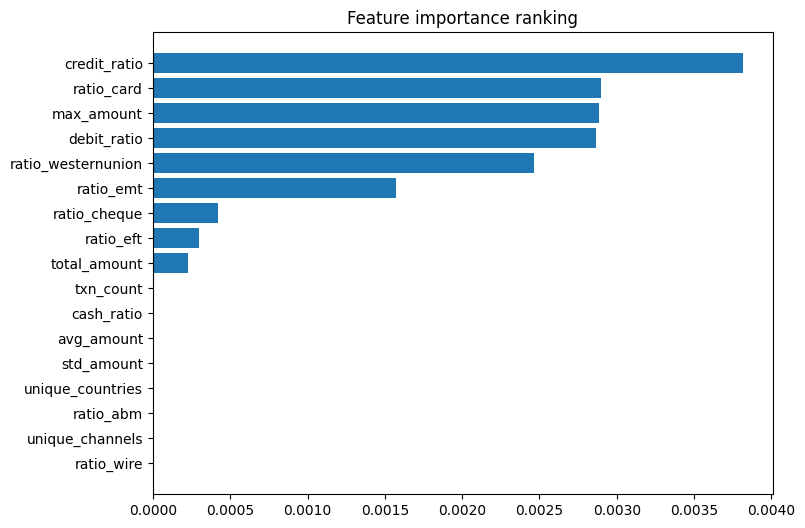

In [15]:
plt.figure(figsize=(8,6))
plt.barh(mi_df["feature"], mi_df["mutual_info"])
plt.gca().invert_yaxis()
plt.title("Feature importance ranking")
plt.show()


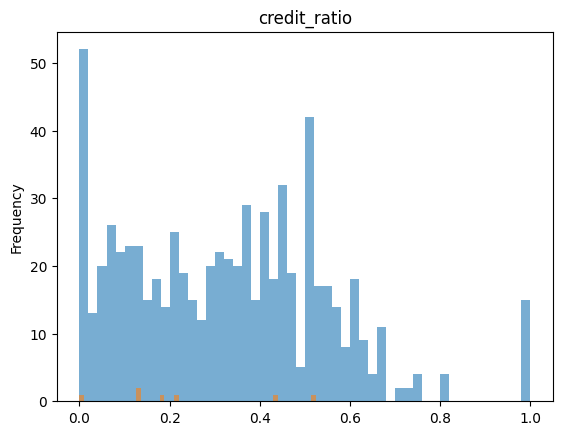

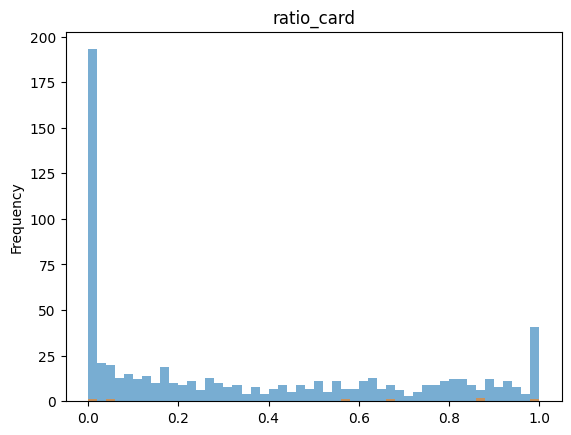

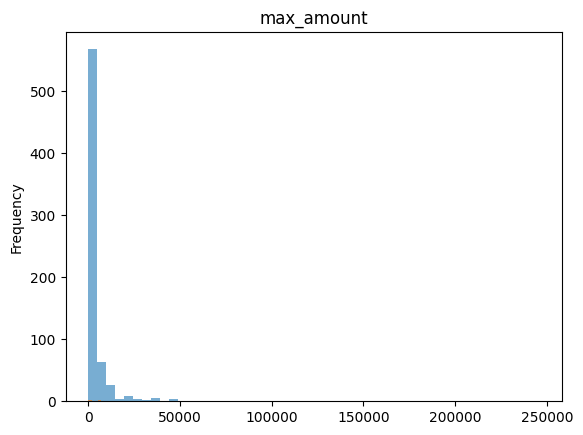

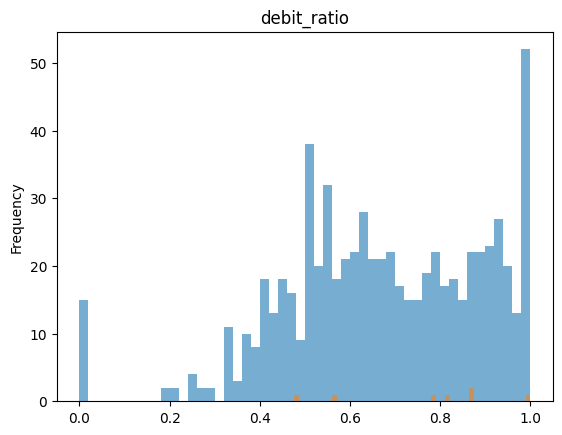

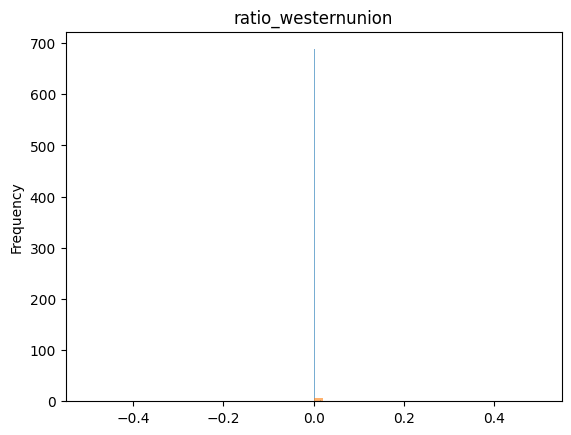

In [16]:
top_features = mi_df.head(5)["feature"]

for f in top_features:
    plt.figure()
    train_df[train_df.label==0][f].dropna().plot(kind="hist", bins=50, alpha=0.6)
    train_df[train_df.label==1][f].dropna().plot(kind="hist", bins=50, alpha=0.6)
    plt.title(f)
    plt.show()


In [17]:
tx = tx.sort_values(["customer_id", "transaction_datetime"])

tx["time_diff"] = tx.groupby("customer_id")["transaction_datetime"].diff().dt.total_seconds()

burst_feat = tx.groupby("customer_id").agg(
    min_time_between_txn=("time_diff", "min"),
    avg_time_between_txn=("time_diff", "mean"),
)

cust_feat = cust_feat.merge(burst_feat, on="customer_id", how="left")


In [18]:
max_time = tx["transaction_datetime"].max()
recent_cutoff = max_time - pd.Timedelta(days=30)

tx["recent"] = tx["transaction_datetime"] >= recent_cutoff

recent_feat = tx.groupby("customer_id").agg(
    recent_txn_ratio=("recent", "mean")
)

cust_feat = cust_feat.merge(recent_feat, on="customer_id", how="left")


In [19]:
vol_feat = tx.groupby("customer_id").agg(
    amount_cv=("amount_cad", lambda x: x.std() / (x.mean()+1e-6))
)

cust_feat = cust_feat.merge(vol_feat, on="customer_id", how="left")


In [20]:
home_country = tx.groupby("customer_id")["country_y"].first()

tx["international"] = tx["country_x"] != tx["country_y"]

intl_feat = tx.groupby("customer_id").agg(
    international_ratio=("international", "mean")
)

cust_feat = cust_feat.merge(intl_feat, on="customer_id", how="left")


In [21]:
def entropy(s):
    p = s.value_counts(normalize=True)
    return -(p*np.log(p+1e-6)).sum()

entropy_feat = tx.groupby("customer_id").agg(
    channel_entropy=("channel", entropy)
)

cust_feat = cust_feat.merge(entropy_feat, on="customer_id", how="left")


In [22]:
train_df = cust_feat.merge(labels, on="customer_id")

from sklearn.feature_selection import mutual_info_classif

X = train_df.drop(columns=["customer_id","label"]).fillna(0)
y = train_df["label"]

mi = mutual_info_classif(X,y)

mi_df = pd.DataFrame({
    "feature": X.columns,
    "mutual_info": mi
}).sort_values("mutual_info", ascending=False)

mi_df


,feature,mutual_info
20,amount_cv,0.004436
6,debit_ratio,0.004303
22,channel_entropy,0.003901
14,ratio_emt,0.003775
11,ratio_card,0.003376
3,max_amount,0.002908
7,credit_ratio,0.002885
21,international_ratio,0.000987
12,ratio_cheque,0.000320
1,total_amount,0.000212


In [23]:
# compute global channel frequencies
channel_freq = tx["channel"].value_counts(normalize=True)

# mark rare channels (<5%)
rare_channels = channel_freq[channel_freq < 0.05].index

tx["is_rare_channel"] = tx["channel"].isin(rare_channels)

rare_channel_feat = tx.groupby("customer_id").agg(
    rare_channel_ratio=("is_rare_channel", "mean")
)

cust_feat = cust_feat.merge(rare_channel_feat, on="customer_id", how="left")


In [24]:
threshold = tx["amount_cad"].quantile(0.95)

tx["is_high_amount"] = tx["amount_cad"] > threshold

high_amt_feat = tx.groupby("customer_id").agg(
    high_amount_ratio=("is_high_amount", "mean")
)

cust_feat = cust_feat.merge(high_amt_feat, on="customer_id", how="left")


In [25]:
country_counts = tx["country_x"].value_counts()

rare_countries = country_counts[country_counts < 50].index

tx["is_rare_country"] = tx["country_x"].isin(rare_countries)

country_feat = tx.groupby("customer_id").agg(
    rare_country_ratio=("is_rare_country", "mean")
)

cust_feat = cust_feat.merge(country_feat, on="customer_id", how="left")


In [26]:
cust_feat["uses_many_channels"] = (cust_feat["unique_channels"] >= 3).astype(int)


In [27]:
cust_feat["is_international_user"] = (cust_feat["international_ratio"] > 0.2).astype(int)


In [28]:
high_txn_threshold = cust_feat["txn_count"].quantile(0.9)

cust_feat["is_high_activity"] = (cust_feat["txn_count"] > high_txn_threshold).astype(int)


In [29]:
burst_threshold = cust_feat["min_time_between_txn"].quantile(0.1)

cust_feat["has_burst_pattern"] = (cust_feat["min_time_between_txn"] < burst_threshold).astype(int)


In [30]:
industry_risk = tx.groupby("industry")["label"].mean()

cust_feat["industry_risk_score"] = cust_feat["customer_id"].map(
    tx.groupby("customer_id")["industry"].first().map(industry_risk)
)


In [31]:
train_df = cust_feat.merge(labels, on="customer_id")

X = train_df.drop(columns=["customer_id","label"]).fillna(0)
y = train_df["label"]

from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X,y)

mi_df = pd.DataFrame({
    "feature": X.columns,
    "mutual_info": mi
}).sort_values("mutual_info", ascending=False)

mi_df


,feature,mutual_info
27,is_international_user,0.062923
26,uses_many_channels,0.016385
14,ratio_emt,0.005094
20,amount_cv,0.004431
7,credit_ratio,0.003352
3,max_amount,0.002908
6,debit_ratio,0.002848
24,high_amount_ratio,0.002742
22,channel_entropy,0.002472
12,ratio_cheque,0.002050


In [32]:
# compute per-customer baseline
baseline = tx.groupby("customer_id")["amount_cad"].agg(["mean","std"]).reset_index()
baseline.columns = ["customer_id","baseline_mean","baseline_std"]

tx2 = tx.merge(baseline, on="customer_id")

tx2["amount_zscore"] = (
    (tx2["amount_cad"] - tx2["baseline_mean"]) /
    (tx2["baseline_std"] + 1e-6)
).abs()

z_feat = tx2.groupby("customer_id").agg(
    max_amount_zscore=("amount_zscore","max"),
    avg_amount_zscore=("amount_zscore","mean"),
)

cust_feat = cust_feat.merge(z_feat, on="customer_id", how="left")


In [33]:
max_time = tx["transaction_datetime"].max()

recent_7 = max_time - pd.Timedelta(days=7)
recent_30 = max_time - pd.Timedelta(days=30)

tx["recent_7"] = tx["transaction_datetime"] >= recent_7
tx["recent_30"] = tx["transaction_datetime"] >= recent_30

recent_feat = tx.groupby("customer_id").agg(
    recent_7_ratio=("recent_7","mean"),
    recent_30_ratio=("recent_30","mean"),
)

cust_feat = cust_feat.merge(recent_feat, on="customer_id", how="left")


In [34]:
tx_sorted = tx.sort_values(["customer_id","transaction_datetime"])

tx_sorted["time_diff"] = (
    tx_sorted.groupby("customer_id")["transaction_datetime"]
    .diff().dt.total_seconds()
)

accel_feat = tx_sorted.groupby("customer_id").agg(
    min_time_diff=("time_diff","min"),
    median_time_diff=("time_diff","median"),
)

cust_feat = cust_feat.merge(accel_feat, on="customer_id", how="left")


In [35]:
industry_fraud_rate = (
    tx.groupby("industry")["label"]
    .mean()
)

cust_feat["industry_risk_score"] = (
    tx.groupby("customer_id")["industry"]
    .first()
    .map(industry_fraud_rate)
)


In [36]:
global_channel_entropy = -(tx["channel"].value_counts(normalize=True)
                          * np.log(tx["channel"].value_counts(normalize=True)+1e-6)).sum()

cust_feat["channel_entropy_anomaly"] = (
    cust_feat["channel_entropy"] - global_channel_entropy
).abs()


In [37]:
global_threshold = tx["amount_cad"].quantile(0.99)

tx["is_extreme_amount"] = tx["amount_cad"] > global_threshold

extreme_feat = tx.groupby("customer_id").agg(
    extreme_txn_ratio=("is_extreme_amount","mean")
)

cust_feat = cust_feat.merge(extreme_feat, on="customer_id", how="left")


In [38]:
home_country = tx.groupby("customer_id")["country_y"].first()

tx["geo_anomaly"] = tx["country_x"] != tx["country_y"]

geo_feat = tx.groupby("customer_id").agg(
    geo_anomaly_ratio=("geo_anomaly","mean")
)

cust_feat = cust_feat.merge(geo_feat, on="customer_id", how="left")


In [39]:
train_df = cust_feat.merge(labels, on="customer_id")

X = train_df.drop(columns=["customer_id","label"]).fillna(0)
y = train_df["label"]

from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X,y)

mi_df = pd.DataFrame({
    "feature": X.columns,
    "mutual_info": mi
}).sort_values("mutual_info", ascending=False)

mi_df.head(20)


,feature,mutual_info
27,is_international_user,0.063876
20,amount_cv,0.004411
6,debit_ratio,0.004314
37,channel_entropy_anomaly,0.004271
14,ratio_emt,0.003971
7,credit_ratio,0.003845
23,rare_channel_ratio,0.003255
3,max_amount,0.002905
22,channel_entropy,0.002469
38,extreme_txn_ratio,0.002395


In [41]:
cols = ["industry", "industry_code", "occupation_title", "occupation_code",
        "country_y", "province_y", "income", "sales", "employee_count", "label"]
[c for c in cols if c in tx.columns]


['industry',
 'industry_code',
 'occupation_title',
 'occupation_code',
 'country_y',
 'province_y',
 'income',
 'sales',
 'employee_count',
 'label']

In [42]:
cust_base = (
    tx.sort_values(["customer_id", "transaction_datetime"])
      .groupby("customer_id")
      .agg(
          kyc_province=("province_y", "first") if "province_y" in tx.columns else ("customer_id","first"),
          industry=("industry", "first") if "industry" in tx.columns else ("customer_id","first"),
          occupation=("occupation_title", "first") if "occupation_title" in tx.columns else ("customer_id","first"),
          avg_amount=("amount_cad","mean"),
          txn_count=("transaction_id","count"),
          total_amount=("amount_cad","sum"),
          amount_cv=("amount_cad", lambda x: x.std()/(x.mean()+1e-6)),
      )
      .reset_index()
)

peer_cols = [c for c in ["kyc_province", "industry"] if c in cust_base.columns]

peer_stats = cust_base.groupby(peer_cols).agg(
    peer_avg_amount=("avg_amount","mean"),
    peer_median_amount=("avg_amount","median"),
    peer_avg_txn_count=("txn_count","mean"),
    peer_avg_cv=("amount_cv","mean"),
).reset_index()

cust_base = cust_base.merge(peer_stats, on=peer_cols, how="left")

cust_base["avg_amount_vs_peer_ratio"] = cust_base["avg_amount"] / (cust_base["peer_avg_amount"] + 1e-6)
cust_base["txn_count_vs_peer_ratio"] = cust_base["txn_count"] / (cust_base["peer_avg_txn_count"] + 1e-6)
cust_base["cv_vs_peer_ratio"] = cust_base["amount_cv"] / (cust_base["peer_avg_cv"] + 1e-6)

cust_base.head()


,customer_id,kyc_province,industry,occupation,avg_amount,txn_count,total_amount,amount_cv,peer_avg_amount,peer_median_amount,peer_avg_txn_count,peer_avg_cv,avg_amount_vs_peer_ratio,txn_count_vs_peer_ratio,cv_vs_peer_ratio
0,SYNID0100000485,ON,Unknown,Unknown,274.783000,40,10991.32,1.569434,396.763937,327.718000,56.100418,1.777500,0.692560,0.713007,0.882944
1,SYNID0100036671,AB,Unknown,Unknown,105.430000,1,105.43,NaN,351.608635,321.679165,63.810345,1.843388,0.299850,0.015671,NaN
2,SYNID0100059315,ON,Unknown,Unknown,1906.900000,1,1906.90,NaN,396.763937,327.718000,56.100418,1.777500,4.806132,0.017825,NaN
3,SYNID0100088505,Unknown,Unknown,Unknown,626.817843,51,31967.71,1.771560,425.885751,277.761951,72.359307,1.909964,1.471798,0.704816,0.927535
4,SYNID0100090388,Unknown,Unknown,Other administrative services managers,299.528350,206,61702.84,4.519598,425.885751,277.761951,72.359307,1.909964,0.703307,2.846904,2.366325


In [43]:
peer_cols2 = [c for c in ["occupation_title", "province_y"] if c in tx.columns]

if peer_cols2:
    cust_occ = (
        tx.groupby("customer_id")
          .agg(
              occupation=("occupation_title","first"),
              kyc_province=("province_y","first") if "province_y" in tx.columns else ("customer_id","first"),
              avg_amount=("amount_cad","mean"),
              txn_count=("transaction_id","count"),
          )
          .reset_index()
    )

    occ_peer = cust_occ.groupby(["occupation","kyc_province"]).agg(
        occ_peer_avg_amount=("avg_amount","mean"),
        occ_peer_avg_txn_count=("txn_count","mean"),
    ).reset_index()

    cust_occ = cust_occ.merge(occ_peer, on=["occupation","kyc_province"], how="left")
    cust_occ["avg_amount_vs_occpeer"] = cust_occ["avg_amount"]/(cust_occ["occ_peer_avg_amount"]+1e-6)
    cust_occ["txn_count_vs_occpeer"] = cust_occ["txn_count"]/(cust_occ["occ_peer_avg_txn_count"]+1e-6)

    cust_base = cust_base.merge(
        cust_occ[["customer_id","avg_amount_vs_occpeer","txn_count_vs_occpeer"]],
        on="customer_id",
        how="left"
    )

cust_base.head()


,customer_id,kyc_province,industry,occupation,avg_amount,txn_count,total_amount,amount_cv,peer_avg_amount,peer_median_amount,peer_avg_txn_count,peer_avg_cv,avg_amount_vs_peer_ratio,txn_count_vs_peer_ratio,cv_vs_peer_ratio,avg_amount_vs_occpeer,txn_count_vs_occpeer
0,SYNID0100000485,ON,Unknown,Unknown,274.783000,40,10991.32,1.569434,396.763937,327.718000,56.100418,1.777500,0.692560,0.713007,0.882944,0.500830,0.773661
1,SYNID0100036671,AB,Unknown,Unknown,105.430000,1,105.43,NaN,351.608635,321.679165,63.810345,1.843388,0.299850,0.015671,NaN,0.095813,0.017388
2,SYNID0100059315,ON,Unknown,Unknown,1906.900000,1,1906.90,NaN,396.763937,327.718000,56.100418,1.777500,4.806132,0.017825,NaN,3.475591,0.019342
3,SYNID0100088505,Unknown,Unknown,Unknown,626.817843,51,31967.71,1.771560,425.885751,277.761951,72.359307,1.909964,1.471798,0.704816,0.927535,0.802771,0.802267
4,SYNID0100090388,Unknown,Unknown,Other administrative services managers,299.528350,206,61702.84,4.519598,425.885751,277.761951,72.359307,1.909964,0.703307,2.846904,2.366325,1.124890,2.032059


In [44]:
cust_fin = (
    tx.groupby("customer_id")
      .agg(
          income=("income","first") if "income" in tx.columns else ("customer_id","first"),
          sales=("sales","first") if "sales" in tx.columns else ("customer_id","first"),
          employee_count=("employee_count","first") if "employee_count" in tx.columns else ("customer_id","first"),
          avg_amount=("amount_cad","mean"),
          total_amount=("amount_cad","sum"),
      )
      .reset_index()
)

# choose one financial column that exists
fin_col = None
for c in ["income","sales","employee_count"]:
    if c in tx.columns:
        fin_col = c
        break

if fin_col:
    cust_fin[fin_col] = pd.to_numeric(cust_fin[fin_col], errors="coerce")
    cust_fin["fin_bucket"] = pd.qcut(cust_fin[fin_col], q=5, duplicates="drop")

    fin_peer = cust_fin.groupby("fin_bucket").agg(
        fin_peer_avg_amount=("avg_amount","mean"),
        fin_peer_avg_total=("total_amount","mean"),
    ).reset_index()

    cust_fin = cust_fin.merge(fin_peer, on="fin_bucket", how="left")
    cust_fin["avg_amount_vs_finpeer"] = cust_fin["avg_amount"]/(cust_fin["fin_peer_avg_amount"]+1e-6)
    cust_fin["total_amount_vs_finpeer"] = cust_fin["total_amount"]/(cust_fin["fin_peer_avg_total"]+1e-6)

    cust_base = cust_base.merge(
        cust_fin[["customer_id","avg_amount_vs_finpeer","total_amount_vs_finpeer"]],
        on="customer_id",
        how="left"
    )

cust_base.head()


C:\Users\shany\AppData\Local\Temp\ipykernel_45692\3744813687.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fin_peer = cust_fin.groupby("fin_bucket").agg(


,customer_id,kyc_province,industry,occupation,avg_amount,txn_count,total_amount,amount_cv,peer_avg_amount,peer_median_amount,peer_avg_txn_count,peer_avg_cv,avg_amount_vs_peer_ratio,txn_count_vs_peer_ratio,cv_vs_peer_ratio,avg_amount_vs_occpeer,txn_count_vs_occpeer,avg_amount_vs_finpeer,total_amount_vs_finpeer
0,SYNID0100000485,ON,Unknown,Unknown,274.783000,40,10991.32,1.569434,396.763937,327.718000,56.100418,1.777500,0.692560,0.713007,0.882944,0.500830,0.773661,0.741438,1.231556
1,SYNID0100036671,AB,Unknown,Unknown,105.430000,1,105.43,NaN,351.608635,321.679165,63.810345,1.843388,0.299850,0.015671,NaN,0.095813,0.017388,0.269107,0.008634
2,SYNID0100059315,ON,Unknown,Unknown,1906.900000,1,1906.90,NaN,396.763937,327.718000,56.100418,1.777500,4.806132,0.017825,NaN,3.475591,0.019342,5.145327,0.213664
3,SYNID0100088505,Unknown,Unknown,Unknown,626.817843,51,31967.71,1.771560,425.885751,277.761951,72.359307,1.909964,1.471798,0.704816,0.927535,0.802771,0.802267,1.587063,1.057005
4,SYNID0100090388,Unknown,Unknown,Other administrative services managers,299.528350,206,61702.84,4.519598,425.885751,277.761951,72.359307,1.909964,0.703307,2.846904,2.366325,1.124890,2.032059,NaN,NaN


In [46]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

X = train_df.drop(columns=["customer_id","label"]).copy()
y = train_df["label"].astype(int)

# detect categorical columns
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

# factorize categorical columns (symbol encoding, not ordinal meaning)
X_encoded = X.copy()

for col in cat_cols:
    X_encoded[col], _ = pd.factorize(X[col])

# fill numeric NaNs
X_encoded[num_cols] = X_encoded[num_cols].fillna(0)

# mark which features are categorical
discrete_mask = [col in cat_cols for col in X_encoded.columns]

mi = mutual_info_classif(
    X_encoded,
    y,
    discrete_features=discrete_mask,
    random_state=42
)

mi_df = (
    pd.DataFrame({
        "feature": X_encoded.columns,
        "mutual_info": mi
    })
    .sort_values("mutual_info", ascending=False)
)

mi_df.head(30)


,feature,mutual_info
1,industry,0.011218
0,kyc_province,0.006378
6,amount_cv,0.004420
17,total_amount_vs_finpeer,0.003895
2,occupation,0.003692
13,cv_vs_peer_ratio,0.003101
5,total_amount,0.000221
8,peer_median_amount,0.000213
4,txn_count,0.000000
3,avg_amount,0.000000


In [51]:
# --- prep ---
tx = txns_train.copy()

# parse datetime
tx["transaction_datetime"] = pd.to_datetime(tx["transaction_datetime"], errors="coerce")
tx = tx.dropna(subset=["transaction_datetime"])

# pick the "transaction country" column (country_x if merged, else country)
txn_country_col = None
for c in ["country_x", "country", "country_txn"]:
    if c in tx.columns:
        txn_country_col = c
        break

# pick the "KYC country" column (country_y if merged, else None)
kyc_country_col = None
for c in ["country_y", "kyc_country"]:
    if c in tx.columns:
        kyc_country_col = c
        break

# sort for time features
tx = tx.sort_values(["customer_id", "transaction_datetime"])

print("txn_country_col:", txn_country_col, "kyc_country_col:", kyc_country_col)
tx.head(2)


txn_country_col: country_x kyc_country_col: country_y


,transaction_id,customer_id,amount_cad,debit_credit,transaction_datetime,cash_indicator,country_x,province_x,city_x,channel,...,income,industry,industry_code,marital_status,occupation_code,occupation_title,onboard_date,province_y,sales,label
27237,EFT24110171256594,SYNID0100000485,1384.68,C,2024-11-01 21:11:16,0,Unknown,Unknown,Unknown,eft,...,19998.0,Unknown,Unknown,Widowed,RETIRED,Unknown,1997-07-12,ON,NaN,0.0
27362,EFT24110314246599,SYNID0100000485,245.52,C,2024-11-03 08:17:47,0,Unknown,Unknown,Unknown,eft,...,19998.0,Unknown,Unknown,Widowed,RETIRED,Unknown,1997-07-12,ON,NaN,0.0


In [52]:
max_t = tx["transaction_datetime"].max()

last7_start = max_t - pd.Timedelta(days=7)
prev30_start = max_t - pd.Timedelta(days=37)  # 30 days window before last7
prev30_end   = last7_start

tx["is_last7"] = tx["transaction_datetime"] >= last7_start
tx["is_prev30"] = (tx["transaction_datetime"] >= prev30_start) & (tx["transaction_datetime"] < prev30_end)

g = tx.groupby("customer_id")

feat_velocity = pd.DataFrame({
    "txn_count_last7": g["is_last7"].sum(),
    "txn_count_prev30": g["is_prev30"].sum(),
    "amt_last7": tx.loc[tx["is_last7"]].groupby("customer_id")["amount_cad"].sum(),
    "amt_prev30": tx.loc[tx["is_prev30"]].groupby("customer_id")["amount_cad"].sum(),
}).fillna(0)

feat_velocity["txn_count_last7_vs_prev30"] = feat_velocity["txn_count_last7"] / (feat_velocity["txn_count_prev30"] + 1e-6)
feat_velocity["amt_last7_vs_prev30"] = feat_velocity["amt_last7"] / (feat_velocity["amt_prev30"] + 1e-6)

feat_velocity.head()


,txn_count_last7,txn_count_prev30,amt_last7,amt_prev30,txn_count_last7_vs_prev30,amt_last7_vs_prev30
customer_id,,,,,,
SYNID0100000485,3,13,746.82,4606.38,0.230769,0.162127
SYNID0100059315,0,0,0.00,0.00,0.000000,0.000000
SYNID0100088505,4,13,2678.04,6708.20,0.307692,0.399219
SYNID0100090388,17,56,1221.19,14465.98,0.303571,0.084418
SYNID0100093807,19,72,1851.08,5512.16,0.263889,0.335818


In [53]:
# Create per-transaction day index relative to each customer
tx["day_idx"] = (tx["transaction_datetime"] - tx.groupby("customer_id")["transaction_datetime"].transform("min")).dt.days

# Compute correlation-like slope proxy: cov(day, amount) / var(day)
def slope_proxy(df):
    d = df["day_idx"].to_numpy()
    a = df["amount_cad"].to_numpy()
    if len(d) < 3 or np.nanvar(d) < 1e-9:
        return 0.0
    d = d - np.nanmean(d)
    a = a - np.nanmean(a)
    return float(np.nansum(d * a) / (np.nansum(d * d) + 1e-6))

trend = tx.groupby("customer_id").apply(slope_proxy).rename("trend_slope_amount")

feat_velocity = feat_velocity.join(trend, how="left").fillna(0)
feat_velocity.head()


C:\Users\shany\AppData\Local\Temp\ipykernel_45692\968384992.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = tx.groupby("customer_id").apply(slope_proxy).rename("trend_slope_amount")


,txn_count_last7,txn_count_prev30,amt_last7,amt_prev30,txn_count_last7_vs_prev30,amt_last7_vs_prev30,trend_slope_amount
customer_id,,,,,,,
SYNID0100000485,3,13,746.82,4606.38,0.230769,0.162127,-0.461773
SYNID0100059315,0,0,0.00,0.00,0.000000,0.000000,0.000000
SYNID0100088505,4,13,2678.04,6708.20,0.307692,0.399219,-2.252252
SYNID0100090388,17,56,1221.19,14465.98,0.303571,0.084418,-0.468613
SYNID0100093807,19,72,1851.08,5512.16,0.263889,0.335818,0.174895


In [54]:
# days since last txn + days since first txn
cust_min = tx.groupby("customer_id")["transaction_datetime"].min()
cust_max = tx.groupby("customer_id")["transaction_datetime"].max()

span_days = (cust_max - cust_min).dt.days.fillna(0)

# inactivity in the middle: max gap between consecutive txns
tx["gap_days"] = tx.groupby("customer_id")["transaction_datetime"].diff().dt.total_seconds() / (3600*24)
max_gap = tx.groupby("customer_id")["gap_days"].max().fillna(0)

# dormancy then recent activity: big gap + last7 activity
dormancy_then_active = ((max_gap >= 30) & (feat_velocity["txn_count_last7"] >= 3)).astype(int)

feat_dorm = pd.DataFrame({
    "max_gap_days": max_gap,
    "span_days": span_days,
    "dormancy_then_active": dormancy_then_active
})

feat_dorm.head()


,max_gap_days,span_days,dormancy_then_active
customer_id,,,
SYNID0100000485,11.640463,90,0
SYNID0100059315,0.000000,0,0
SYNID0100088505,8.660741,91,0
SYNID0100090388,1.946076,91,0
SYNID0100093807,2.367280,91,0


In [55]:
feat_intl = pd.DataFrame(index=tx["customer_id"].unique())

if txn_country_col and kyc_country_col:
    tx["is_international"] = (tx[txn_country_col].astype(str) != tx[kyc_country_col].astype(str))
else:
    # fallback: if only txn country exists, treat non-CA as international (adjust if needed)
    if txn_country_col:
        tx["is_international"] = (tx[txn_country_col].astype(str) != "CA")
    else:
        tx["is_international"] = False

g = tx.groupby("customer_id")

feat_intl["is_international_user"] = g["is_international"].any().astype(int)
feat_intl["international_ratio"] = g["is_international"].mean()

# countries per month (geographic expansion rate)
tx["month"] = tx["transaction_datetime"].dt.to_period("M").astype(str)
if txn_country_col:
    countries_per_month = tx.groupby(["customer_id","month"])[txn_country_col].nunique().groupby("customer_id").mean()
    feat_intl["countries_per_month"] = countries_per_month

# first international after days (time to first intl)
first_time = g["transaction_datetime"].min()
first_intl_time = tx.loc[tx["is_international"]].groupby("customer_id")["transaction_datetime"].min()

feat_intl["first_international_after_days"] = (first_intl_time - first_time).dt.days
feat_intl["first_international_after_days"] = feat_intl["first_international_after_days"].fillna(-1)

# international concentration: if international, is it mostly 1 country?
if txn_country_col:
    intl = tx.loc[tx["is_international"]].copy()
    top_share = (
        intl.groupby("customer_id")[txn_country_col]
        .apply(lambda s: s.value_counts(normalize=True).max() if len(s) else 0.0)
    )
    feat_intl["international_concentration"] = top_share.fillna(0)

feat_intl = feat_intl.fillna(0)
feat_intl.head()


,is_international_user,international_ratio,countries_per_month,first_international_after_days,international_concentration
SYNID0100000485,1,0.525000,2.000000,0.0,1.000000
SYNID0100059315,1,1.000000,1.000000,0.0,1.000000
SYNID0100088505,1,1.000000,1.000000,0.0,1.000000
SYNID0100090388,1,0.523316,3.000000,0.0,0.970297
SYNID0100093807,1,0.191304,2.666667,2.0,0.931818


In [56]:
tx["prev_channel"] = tx.groupby("customer_id")["channel"].shift(1)
tx["channel_switch"] = (tx["channel"] != tx["prev_channel"]).astype(int)
tx.loc[tx["prev_channel"].isna(), "channel_switch"] = 0

switch_rate = tx.groupby("customer_id")["channel_switch"].mean()

# channel concentration gini (inequality) based on channel counts
def gini(counts):
    x = np.array(counts, dtype=float)
    if x.sum() == 0:
        return 0.0
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    return float((n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n)

channel_counts = pd.crosstab(tx["customer_id"], tx["channel"])
channel_gini = channel_counts.apply(lambda row: gini(row.values), axis=1)

feat_channel = pd.DataFrame({
    "channel_switch_frequency": switch_rate,
    "channel_concentration_gini": channel_gini
}).fillna(0)

feat_channel.head()


,channel_switch_frequency,channel_concentration_gini
customer_id,,
SYNID0100000485,0.550000,0.570000
SYNID0100059315,0.000000,0.800000
SYNID0100088505,0.590909,0.618182
SYNID0100090388,0.523316,0.596891
SYNID0100093807,0.104348,0.768696


In [57]:
amt = tx["amount_cad"].fillna(0).astype(float)

# avg cents: suspicious if always .00
tx["cents"] = (amt - np.floor(amt)).round(2)
avg_cents = tx.groupby("customer_id")["cents"].mean()

# round number ratio: exact multiples of 100 or 1000 (tune if needed)
tx["is_round_100"] = (amt % 100 == 0)
tx["is_round_1000"] = (amt % 1000 == 0)
round_ratio = tx.groupby("customer_id")[["is_round_100","is_round_1000"]].mean()

# structuring just under 10k (common AML threshold) -> 9500-9999 range
tx["near_10k"] = ((amt >= 9500) & (amt < 10000))
near_10k_ratio = tx.groupby("customer_id")["near_10k"].mean()

feat_round = round_ratio.copy()
feat_round["avg_cents_component"] = avg_cents
feat_round["structured_amount_pattern"] = near_10k_ratio
feat_round = feat_round.fillna(0)

feat_round.head()


,is_round_100,is_round_1000,avg_cents_component,structured_amount_pattern
customer_id,,,,
SYNID0100000485,0.000000,0.000000,0.533000,0.0
SYNID0100059315,0.000000,0.000000,0.900000,0.0
SYNID0100088505,0.000000,0.000000,0.487955,0.0
SYNID0100090388,0.025907,0.020725,0.496995,0.0
SYNID0100093807,0.026087,0.026087,0.454957,0.0


In [58]:
# customer labels (train split should be labeled)
cust_labels = customers_train[["customer_id","label"]].copy()
cust_labels["label"] = pd.to_numeric(cust_labels["label"], errors="coerce").astype(int)

# combine feature blocks
features = (
    cust_labels.set_index("customer_id")
    .join(feat_velocity, how="left")
    .join(feat_dorm, how="left")
    .join(feat_intl, how="left")
    .join(feat_channel, how="left")
    .join(feat_round, how="left")
    .fillna(0)
    .reset_index()
)

features.shape, features.head()


((700, 23),
        customer_id  label  txn_count_last7  txn_count_prev30  amt_last7  \
 0  SYNID0108676505      0              0.0               0.0       0.00   
 1  SYNID0104294551      0              7.0              13.0    5123.21   
 2  SYNID0108958094      0              0.0              14.0       0.00   
 3  SYNID0102414463      0              4.0              28.0    1355.12   
 4  SYNID0100000485      0              3.0              13.0     746.82   
 
    amt_prev30  txn_count_last7_vs_prev30  amt_last7_vs_prev30  \
 0        0.00                   0.000000             0.000000   
 1     3307.97                   0.538461             1.548747   
 2     1543.52                   0.000000             0.000000   
 3    10653.59                   0.142857             0.127198   
 4     4606.38                   0.230769             0.162127   
 
    trend_slope_amount  max_gap_days  ...  international_ratio  \
 0            0.000000      0.000000  ...             0.000000   


In [59]:
from sklearn.feature_selection import mutual_info_classif

X = features.drop(columns=["customer_id","label"]).copy()
y = features["label"].astype(int)

mi = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({"feature": X.columns, "mutual_info": mi}).sort_values("mutual_info", ascending=False)

mi_df.head(30)


,feature,mutual_info
10,is_international_user,0.043690
14,international_concentration,0.037166
13,first_international_after_days,0.006307
19,avg_cents_component,0.003495
6,trend_slope_amount,0.003310
8,span_days,0.001559
16,channel_concentration_gini,0.000392
15,channel_switch_frequency,0.000119
4,txn_count_last7_vs_prev30,0.000000
0,txn_count_last7,0.000000


In [60]:
import pandas as pd

# For each feature with MI=0
for col in ['txn_count_last7', 'dormancy_then_active', 'is_round_100']:
    print(f"\n{col}:")
    print(features[col].value_counts())
    print(f"NaN count: {features[col].isna().sum()}")
    print(f"Unique values: {features[col].nunique()}")


txn_count_last7:
txn_count_last7
0.0     135
1.0     104
2.0      82
3.0      70
4.0      53
5.0      45
6.0      36
7.0      36
8.0      23
9.0      20
11.0     16
10.0     16
14.0      8
17.0      8
13.0      8
12.0      6
15.0      6
19.0      6
18.0      3
22.0      3
34.0      2
30.0      2
29.0      2
21.0      2
24.0      1
28.0      1
16.0      1
26.0      1
27.0      1
25.0      1
41.0      1
53.0      1
Name: count, dtype: int64
NaN count: 0
Unique values: 32

dormancy_then_active:
dormancy_then_active
0.0    698
1.0      2
Name: count, dtype: int64
NaN count: 0
Unique values: 2

is_round_100:
is_round_100
0.000000    345
0.034483      8
0.035714      6
0.038462      6
0.033333      6
           ... 
0.012500      1
0.080000      1
0.094891      1
0.032609      1
0.034286      1
Name: count, Length: 220, dtype: int64
NaN count: 0
Unique values: 220


In [63]:
tx = txns_train.copy()

tx["transaction_datetime"] = pd.to_datetime(tx["transaction_datetime"], errors="coerce")
tx = tx.dropna(subset=["transaction_datetime", "customer_id"])

# choose transaction country col
txn_country_col = None
for c in ["country_x", "country", "transaction_country"]:
    if c in tx.columns:
        txn_country_col = c
        break

# choose KYC country col
kyc_country_col = None
for c in ["country_y", "kyc_country"]:
    if c in tx.columns:
        kyc_country_col = c
        break

print("txn_country_col:", txn_country_col, "kyc_country_col:", kyc_country_col)

tx = tx.sort_values(["customer_id", "transaction_datetime"])
tx.head()


txn_country_col: country_x kyc_country_col: country_y


,transaction_id,customer_id,amount_cad,debit_credit,transaction_datetime,cash_indicator,country_x,province_x,city_x,channel,...,income,industry,industry_code,marital_status,occupation_code,occupation_title,onboard_date,province_y,sales,label
27237,EFT24110171256594,SYNID0100000485,1384.68,C,2024-11-01 21:11:16,0,Unknown,Unknown,Unknown,eft,...,19998.0,Unknown,Unknown,Widowed,RETIRED,Unknown,1997-07-12,ON,NaN,0.0
27362,EFT24110314246599,SYNID0100000485,245.52,C,2024-11-03 08:17:47,0,Unknown,Unknown,Unknown,eft,...,19998.0,Unknown,Unknown,Widowed,RETIRED,Unknown,1997-07-12,ON,NaN,0.0
3172,CARD24110717190588,SYNID0100000485,126.60,D,2024-11-07 13:07:18,0,CA,AB,other,card,...,19998.0,Unknown,Unknown,Widowed,RETIRED,Unknown,1997-07-12,ON,NaN,0.0
5020,CARD24111441001215,SYNID0100000485,2.50,D,2024-11-14 16:52:23,0,CA,ON,TORONTO,card,...,19998.0,Unknown,Unknown,Widowed,RETIRED,Unknown,1997-07-12,ON,NaN,0.0
5033,CARD24111493035658,SYNID0100000485,131.47,D,2024-11-14 17:31:08,0,CA,NB,SAINT JOHN,card,...,19998.0,Unknown,Unknown,Widowed,RETIRED,Unknown,1997-07-12,ON,NaN,0.0


In [64]:
def safe_entropy_from_probs(p: np.ndarray) -> float:
    """Shannon entropy (nats) from probability vector p."""
    p = np.asarray(p, dtype=float)
    p = p[p > 0]
    if len(p) == 0:
        return 0.0
    return float(-(p * np.log(p)).sum())

def probs_from_series(s: pd.Series) -> np.ndarray:
    """Normalized value counts -> probability vector."""
    vc = s.value_counts(dropna=False, normalize=True)
    return vc.to_numpy()

def channel_gini_like(df: pd.DataFrame) -> float:
    """
    You wrote: 1 - sum(p^2). This is actually Simpson diversity (a concentration inverse).
    Higher = more diverse / less concentrated.
    """
    p = probs_from_series(df["channel"])
    return float(1.0 - np.sum(p ** 2))


In [65]:
def build_velocity_intl_concentration_features(tx: pd.DataFrame) -> pd.DataFrame:
    feats = []

    for cust_id, df in tx.groupby("customer_id", sort=False):
        df = df.sort_values("transaction_datetime")
        n = len(df)
        f = {"customer_id": cust_id}

        # ---------- 1) RELATIVE recent activity (own baseline) ----------
        k = max(1, int(n * 0.3))
        recent = df.tail(k)
        old = df.head(k)

        f["recent_txn_count_ratio"] = n / (len(old) + 1)  # (your formula uses len(recent)/len(old); recent≈k
        f["recent_amount_ratio"] = recent["amount_cad"].sum() / (old["amount_cad"].sum() + 1e-9)

        # ---------- 2) ACCELERATION ----------
        f["txn_frequency_acceleration"] = f["recent_txn_count_ratio"] - 1.0

        # ---------- 3) BURSTINESS ----------
        if n >= 2:
            td = df["transaction_datetime"].diff().dt.total_seconds().dropna()
            if len(td) > 1 and td.mean() > 0:
                f["activity_burstiness"] = float(td.std() / (td.mean() + 1e-9))
            else:
                f["activity_burstiness"] = 0.0
        else:
            f["activity_burstiness"] = 0.0

        # ---------- international features ----------
        # define international mask
        if txn_country_col and kyc_country_col:
            intl_mask = df[txn_country_col].astype(str) != df[kyc_country_col].astype(str)
        elif txn_country_col:
            intl_mask = df[txn_country_col].astype(str) != "CA"  # fallback
        else:
            intl_mask = pd.Series([False]*n, index=df.index)

        intl_txns = df.loc[intl_mask]

        f["is_international_user"] = int(len(intl_txns) > 0)
        f["international_ratio"] = float(intl_mask.mean()) if n > 0 else 0.0

        # pct_history_before_intl + intl size bias + diversity
        if n > 0 and len(intl_txns) > 0:
            first_txn = df["transaction_datetime"].min()
            last_txn = df["transaction_datetime"].max()
            first_intl = intl_txns["transaction_datetime"].min()

            denom = (last_txn - first_txn + pd.Timedelta(days=1))
            f["pct_history_before_intl"] = float((first_intl - first_txn) / denom)

            f["intl_avg_amount_ratio"] = float(
                intl_txns["amount_cad"].mean() / (df["amount_cad"].mean() + 1e-9)
            )

            if txn_country_col:
                f["intl_country_diversity"] = float(
                    intl_txns[txn_country_col].nunique() / (len(intl_txns) + 1)
                )
            else:
                f["intl_country_diversity"] = 0.0
        else:
            f["pct_history_before_intl"] = -1.0
            f["intl_avg_amount_ratio"] = 0.0
            f["intl_country_diversity"] = 0.0

        # ---------- concentration / entropy features ----------
        # Channel gini-like (Simpson diversity)
        if "channel" in df.columns:
            f["channel_gini"] = channel_gini_like(df)
        else:
            f["channel_gini"] = 0.0

        # Amount entropy using binned distribution
        if n > 0:
            try:
                bins = pd.cut(df["amount_cad"].astype(float), bins=10)
                p = probs_from_series(bins)
                f["amount_entropy"] = safe_entropy_from_probs(p)
            except Exception:
                f["amount_entropy"] = 0.0
        else:
            f["amount_entropy"] = 0.0

        # Temporal entropy over hour of day
        if n > 0:
            hour = df["transaction_datetime"].dt.hour
            p = probs_from_series(hour)
            f["temporal_entropy"] = safe_entropy_from_probs(p)
        else:
            f["temporal_entropy"] = 0.0

        # ---------- velocity_trend (rolling window proxy, no weird rolling.apply) ----------
        # use positions to define early vs late velocity
        if n >= 10:
            # average inter-arrival (seconds): compare early vs late
            td = df["transaction_datetime"].diff().dt.total_seconds().dropna()
            # split td into early/late chunks aligned with txns
            td = td.to_numpy()
            if len(td) >= 8:
                early = np.mean(td[: max(1, len(td)//5)])
                late  = np.mean(td[-max(1, len(td)//5):])
                # smaller gap => higher velocity; so ratio early/late
                f["velocity_trend"] = float((early + 1e-9) / (late + 1e-9))
            else:
                f["velocity_trend"] = 1.0
        else:
            f["velocity_trend"] = 1.0

        feats.append(f)

    return pd.DataFrame(feats)


In [66]:
feat_new = build_velocity_intl_concentration_features(tx)

train_labels = customers_train[["customer_id", "label"]].drop_duplicates().copy()
train_labels["label"] = pd.to_numeric(train_labels["label"], errors="coerce").astype(int)

train_feat = train_labels.merge(feat_new, on="customer_id", how="left").fillna(0)

train_feat.shape, train_feat.head()


((700, 15),
        customer_id  label  recent_txn_count_ratio  recent_amount_ratio  \
 0  SYNID0108676505      0                0.000000             0.000000   
 1  SYNID0104294551      0                3.153846             4.026649   
 2  SYNID0108958094      0                3.272727             0.824765   
 3  SYNID0102414463      0                3.230769             0.997088   
 4  SYNID0100000485      0                3.076923             0.690949   
 
    txn_frequency_acceleration  activity_burstiness  is_international_user  \
 0                    0.000000             0.000000                    0.0   
 1                    2.153846             1.016159                    1.0   
 2                    2.272727             0.890328                    1.0   
 3                    2.230769             0.958290                    1.0   
 4                    2.076923             1.156476                    1.0   
 
    international_ratio  pct_history_before_intl  intl_avg_amount_

In [67]:
from sklearn.feature_selection import mutual_info_classif

X = train_feat.drop(columns=["customer_id", "label"]).copy()
y = train_feat["label"].astype(int)

mi = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({"feature": X.columns, "mutual_info": mi}).sort_values("mutual_info", ascending=False)

mi_df.head(30)


,feature,mutual_info
4,is_international_user,0.063161
1,recent_amount_ratio,0.005571
6,pct_history_before_intl,0.003631
10,amount_entropy,0.002389
7,intl_avg_amount_ratio,0.001552
3,activity_burstiness,0.000000
2,txn_frequency_acceleration,0.000000
0,recent_txn_count_ratio,0.000000
5,international_ratio,0.000000
8,intl_country_diversity,0.000000
